# Etapa 2 del proyecto. La tarea de clasificación: árboles de decisión y K-vecinos más cercanos
**By: Alejandra Ossa Yepes**

El conjunto de datos está relacionado con muestras de agua tomadas de diferentes fuentes, caracterizadas por variables fisicoquímicas y anotadas por los expertos, indicando cuáles son aptas para el consumo y cuáles no.

1. Aplicar técnicas de clasificación basadas en árboles de decisión y K-vecinos más cercanos para construir modelos predictivos que permitan estimar la calidad del agua de una zona determinada.

2. Determinar cuáles son los factores que más inciden en la contaminación de los cuerpos de agua con base en los datos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, validation_curve, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### 1. Carga de datos

In [2]:
data_raw=pd.read_excel('Datos_Etapa-2.xlsx')

In [3]:
data_raw.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
0,NaN,204.89,20791.32,7.30,368.52,564.31,10.38,86.99,2.96,NO
1,3.72,129.42,18630.06,6.64,NaN,592.89,15.18,56.33,4.50,NO
2,8.10,224.24,19909.54,9.28,NaN,418.61,16.87,66.42,3.06,NO
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,NO
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,NO


In [4]:
data_raw.describe()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000
mean,7.080804,196.369481,22014.092415,7.122241,333.775784,426.205171,14.284921,66.396281,3.966731
std,1.594369,32.879680,8768.570852,1.583143,41.416864,80.824123,3.308232,16.174983,0.780354
min,0.000000,47.430000,320.940000,0.350000,129.000000,181.480000,2.200000,0.740000,1.450000
25%,6.090000,176.847500,15666.687500,6.130000,307.695000,365.735000,12.070000,55.847500,3.440000
50%,7.040000,196.965000,20927.830000,7.130000,333.070000,421.885000,14.220000,66.620000,3.955000
75%,8.060000,216.670000,27332.760000,8.112500,359.950000,481.790000,16.560000,77.337500,4.500000
max,14.000000,323.120000,61227.200000,13.130000,481.030000,753.340000,28.300000,124.000000,6.740000


In [5]:
data_raw['Potabilidad'].value_counts()

NO    1998
SI    1278
Name: Potabilidad, dtype: int64

### 2. Preparación de los Datos

In [6]:
data = data_raw.copy()

In [7]:
data.duplicated().sum()

0

In [8]:
data.isna().sum()

pH                  491
Dureza                0
Sólidos               0
Cloraminas            0
Sulfatos            781
Conductividad         0
Carbono_orgánico      0
Trihalometanos      162
Turbidez              0
Potabilidad           0
dtype: int64

### 3. División de datos

Ahora dividiremos el conjunto de datos resultante en un conjunto de entrenamiento y uno de pruebas. Usaremos el 80% de los datos para el entrenamiento y el 20% restante para las pruebas

In [9]:
train, test = train_test_split(data, test_size=0.2, random_state=77)
train.head()

,pH,Dureza,Sólidos,Cloraminas,Sulfatos,Conductividad,Carbono_orgánico,Trihalometanos,Turbidez,Potabilidad
3126,6.67,155.71,30610.05,8.17,337.17,425.69,15.10,79.78,4.90,SI
3147,6.26,130.37,9734.68,10.28,320.36,399.35,10.85,43.42,3.93,SI
2844,6.66,182.39,16828.88,7.07,355.90,434.66,16.62,69.41,3.97,SI
1916,8.02,255.26,30854.83,8.76,NaN,442.50,11.09,93.27,5.32,SI
1053,8.92,207.52,13291.92,8.56,357.94,468.54,15.69,107.28,4.08,NO


In [10]:
x_train = train.drop(['Potabilidad'],axis=1)
y_train = train['Potabilidad']

### 4. Transformación

Para especificar qué variables deben ser modificadas por cada uno de los objetos utilizaremos un objeto de la clase ColumnTransformer(), que recibe una lista de tuplas (nombre, objeto, columnas) especificando qué objeto se usará con qué conjunto de variables:

In [11]:
data.columns.get_indexer(['pH', 'Dureza', 'Sólidos', 'Cloraminas', 'Sulfatos', 'Conductividad','Carbono_orgánico', 'Trihalometanos', 'Turbidez'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [12]:
scaler = StandardScaler()
numeric_features = [0,1, 2,3 ,4, 5, 6, 7, 8]
column_transformer = ColumnTransformer(
    transformers=[
        ("num", scaler, numeric_features)
    ]
)

Se realiza una imputación de datos para reemplazar los valores nulos por valores como la media, mediana, entre otros. En ese sentido, definiremos un objeto de la clase `SimpleImputer()`, especificando que reemplazaremos los valores nulos por el valor más frecuente.

In [13]:
simple_imputer = SimpleImputer(strategy='most_frequent')
steps = [
    ("imputer",simple_imputer),
    ("transformer",column_transformer)
]

In [14]:
pipeline = Pipeline(steps)

Se utilizara el pipeline de preprocesamiento para transformar el conjunto de datos mediante la función fit_transform()

In [15]:
columns = x_train.columns
x_train_transformed = pipeline.fit_transform(x_train)
x_train_transformed = pd.DataFrame(x_train_transformed, columns=columns)

### 5. Decision TreeClassifier

In [16]:
decision_tree = DecisionTreeClassifier(random_state=0, class_weight='balanced')

In [17]:
param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [4,6,8,10,12],
    'min_samples_split': [3, 4, 5]
}

In [18]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [19]:
grid_dt = GridSearchCV(decision_tree, param_grid, cv=kfold, n_jobs=-1)

In [20]:
grid_dt.fit(x_train_transformed, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [4, 6, 8, 10, 12],
                         'min_samples_split': [3, 4, 5]})

In [21]:
print("Mejores parámetros: {}".format(grid_dt.best_params_))

Mejores parámetros: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 3}


In [22]:
mejor_modelo_dt = grid_dt.best_estimator_

In [23]:
importancia_dt = mejor_modelo_dt.feature_importances_
importancia_dt = pd.DataFrame(data={'Variable':x_train.columns, 'Importancia':importancia_dt})
importancia_dt.sort_values('Importancia', ascending=False)

,Variable,Importancia
0,pH,0.256573
4,Sulfatos,0.225758
1,Dureza,0.142441
2,Sólidos,0.097465
5,Conductividad,0.071704
6,Carbono_orgánico,0.061909
3,Cloraminas,0.055538
7,Trihalometanos,0.048052
8,Turbidez,0.040561


In [24]:
x_test = test.drop(['Potabilidad'],axis=1)
y_test = test['Potabilidad']

Con la información disponible del conjunto de entrenamiento, haremos uso de la función `transform()` del pipeline para transformar el conjunto de pruebas

In [25]:
columns = x_test.columns
x_test_transformed = pipeline.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=columns)

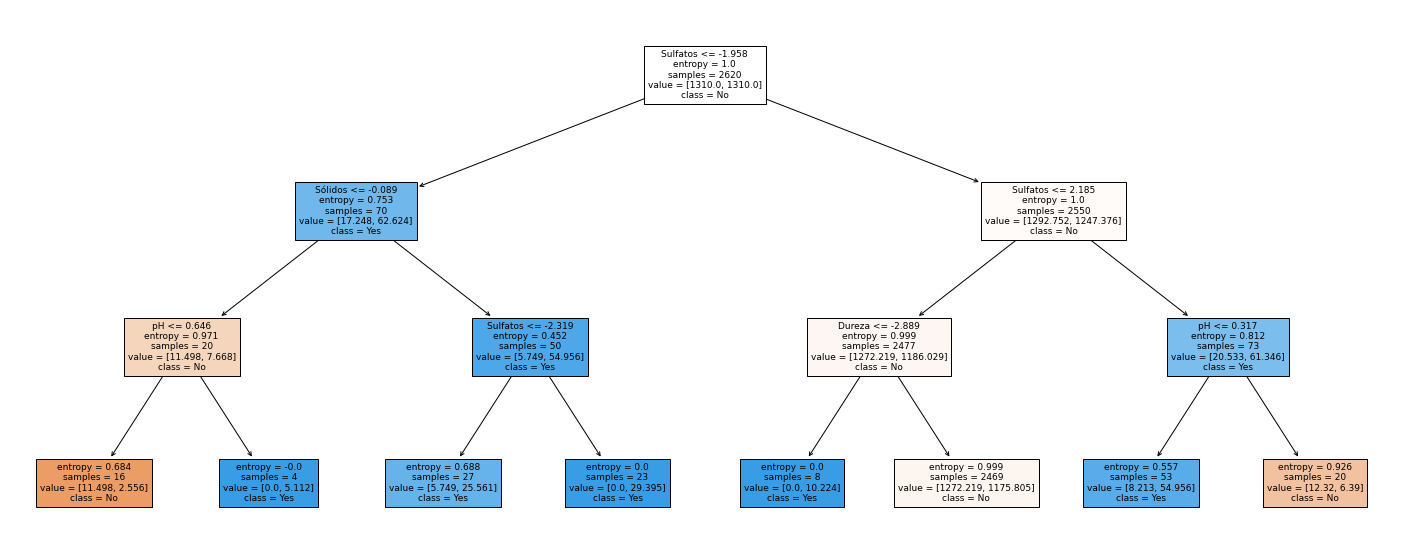

In [26]:
deciscion_tree_prueba = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3 ,class_weight = 'balanced', random_state = 0, min_samples_split = 3)
deciscion_tree_prueba.fit(x_train_transformed, y_train)
plt.figure(figsize=(25,10))
tree = plot_tree(deciscion_tree_prueba, feature_names=list(columns), class_names=['No','Yes'], filled=True, fontsize=9)

#### *Reglas de Decision*

> El nodo raiz es el Sulfatos, el cual cuanta con una entropy =1 
1. Cuando Sulfatos <=-1.95 y Sólidos <=-0.089 y PH <= 0.646 Entonces No_Potable
2. Cuando Sulfatos <=-1.95 y Sólidos <=-0.089 y PH > 0.646 Entonces SI_Potable
3. Cuando Sulfatos <=-1.95 y Sólidos >-0.089 y Sulfatos <= -2.319 Entonces SI_Potable
4. Cuando Sulfatos <=-1.95 y Sólidos >-0.089 y Sulfatos > -2.319 Entonces SI_Potable
5. -1.95 < Sulfatos <= -2.319 y Dureza <= -2.889 Entonces SI_Potable
6. -1.95 < Sulfatos <= -2.319 <= -2.319 y Dureza > -2.889 Entonces NO_Potable
7. -1.95 < Sulfatos <= -2.319 y PH <= 0.317 Entonces SI_Potable
8. -1.95 < Sulfatos <= -2.319 y PH > 0.317 Entonces NO_Potable

In [28]:
y_pred_dt = mejor_modelo_dt.predict(x_test_transformed)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
recall_dt= recall_score(y_test, y_pred_dt, average="binary", pos_label='SI')
precision_dt = precision_score(y_test, y_pred_dt,  average="binary", pos_label='SI')
f1_score_dt = f1_score(y_test, y_pred_dt,  average="binary", pos_label='SI')
print('------ Modelo de Decision Tree -------')
print("Exactitud: ", accuracy_dt)
print("Sensibilidad: ", recall_dt)
print('Precisión: ', precision_dt)
print('F1-Score: ', f1_score_dt)

------ Modelo de Decision Tree -------
Exactitud:  0.4740853658536585
Sensibilidad:  0.8181818181818182
Precisión:  0.4090909090909091
F1-Score:  0.5454545454545455


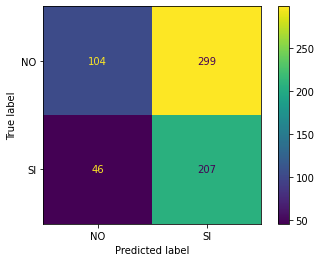

In [29]:
cm = confusion_matrix(y_test, y_pred_dt, labels=grid_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_dt.classes_)
disp.plot()
plt.show()

### 6. K-Nearest-Neighbor

In [30]:
KNN = KNeighborsClassifier()

In [31]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [32]:
n_neighbors = [1, 2, 3, 4, 5]
algorithm = ["auto",  "ball_tree", "kd_tree", "brute"]

In [33]:
parameters = {'n_neighbors': n_neighbors,
              'algorithm': algorithm}

Se crea el mejor modelo utilizando los siguientes parametros, y se entrena sobre el conjunto de entrenamiento transformado por medio de pipeline, haciendo uso de la función `fit()`, almacenando el resultado en la variable mejor_modelo:

In [34]:
grid_knn = GridSearchCV(KNN, parameters,cv=kfold, n_jobs=-1)

In [35]:
grid_knn.fit(x_train_transformed.values, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5]})

In [36]:
print("Mejores parámetros: {}".format(grid_knn.best_params_))

Mejores parámetros: {'algorithm': 'auto', 'n_neighbors': 4}


In [37]:
mejor_modelo_knn = grid_knn.best_estimator_

In [38]:
y_pred_knn = mejor_modelo_knn.predict(x_test_transformed)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn, average="binary", pos_label='SI')
precision_knn = precision_score(y_test, y_pred_knn,  average="binary", pos_label='SI')
f1_score_knn = f1_score(y_test, y_pred_knn,  average="binary", pos_label='SI')
print('------ Modelo de KNN -------')
print("Exactitud: ", accuracy_knn)
print("Sensibilidad: ", recall_knn)
print('Precisión: ', precision_knn)
print('F1-Score: ', f1_score_knn)

------ Modelo de KNN -------
Exactitud:  0.6432926829268293
Sensibilidad:  0.24110671936758893
Precisión:  0.5922330097087378
F1-Score:  0.34269662921348315


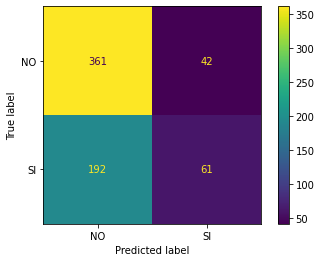

In [39]:
cm = confusion_matrix(y_test, y_pred_knn, labels=grid_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_knn.classes_)
disp.plot()
plt.show()

### 7. Tabla comparativa

In [40]:
tb_f = pd.DataFrame(np.array([['DecisionTreeClassifier()',  round(accuracy_dt, 2), round(recall_dt, 2), round(precision_dt,2), round(f1_score_dt,2)],
                              ['KNeighborsClassifier()', round(accuracy_knn,2), round(recall_knn, 2),  round(precision_knn,2), round(f1_score_knn,2)]]),
                   columns=['Model','Exactitud','Sensibilidad','Precisión','F1-Score'])

In [41]:
tb_f

,Model,Exactitud,Sensibilidad,Precisión,F1-Score
0,DecisionTreeClassifier(),0.47,0.82,0.41,0.55
1,KNeighborsClassifier(),0.64,0.24,0.59,0.34


### 8. Preguntas
- **¿Qué puedes decir de los valores de las métricas recall y precisión para cada una de las clases en cada modelo? ¿Cuál de estás métricas consideras que es más importante con base en la descripción del problema?**  Debido a la cuasistica presentada seria mas apropiado tener encuenta una presicion alta, debido a que nos interesa que sea mayor la proporción de las predicciones positivas. Cuanto mayor sea la precisión, menos falsos positivos tiene el modelo ya que no queremos caracteristicas de aguas que no son apta sean potable.

- **¿Consideras que el rendimiento de los modelos es adecuado? Si no es así, ¿cómo podrían mejorarse los resultados?** El rendimiento del modelo k-vecinos no tiene valores muy altos, esto podria mejorarse con un balanceo de clases ya que su proporción no se encuntra uniforme.

- **¿Cuáles son las variables más significativas según el mejor modelo basado en árboles de decisión? Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema**  las variables mas importantes son Sulfatos, pH, Dureza y Sólidos, las cuales hacen parte del arbol de desición  y las que mejor entropia tienen para la clasificacion. Ademas su importancia es la mas significante.
| Variables | Importancia |
|----------|-------------|
| PH       | 0.256573    |
| Sulfatos | 0.225758    |
| Dureza   | 0.142441    |
| Sólidos  | 0.097465    |

- **Si los dos modelos proporcionan resultados similares en cuanto a las métricas de rendimiento ¿Cuál seleccionarías tomando en cuenta el contexto del problema?** Debido a las caracteristicas, elegiria el arbol de decision ya que es menos complejo y con mayor explicabilidad que el algoritmo de K-vecinos.
|                    Model | Exactitud | Sensibilidad | Precisión | F1-Score |
|-------------------------:|----------:|-------------:|----------:|---------:|
| DecisionTreeClassifier() |      0.47 |         0.82 |      0.41 |     0.55 |
|   KNeighborsClassifier() |      0.64 |         0.24 |      0.59 |     0.34 |

## Cierre
---
*Creado por: Alejandra Ossa Yepes*   
*Versión de: Septiembre 18, 2022*  
*Universidad de los Andes*   